In [ ]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


(7840, 400)


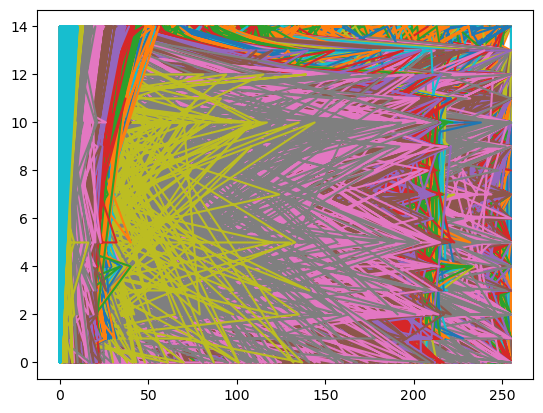

In [ ]:
dataset = np.load("dataset.npz")

X, y = dataset["X"], dataset["y"]


X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

In [ ]:
pca = PCA()

pca.fit(X_train)




KeyboardInterrupt: 

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Porcentaje deseado
target_variance = 0.95  # 95%

# Número mínimo de componentes para alcanzar target
n_components = np.argmax(cumulative_variance >= target_variance) + 1

In [ ]:
pca.transform()